In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as trans_f

sys.path.append(os.path.abspath(sys.path[0] + '/../../'))
__package__ = "deep_view_syn.notebook"
torch.cuda.set_device(2)
print("Set CUDA:%d as current device." % torch.cuda.current_device())

from ..data.spherical_view_syn import *
from ..msl_net import MslNet
from ..configs.spherical_view_syn import SphericalViewSynConfig
from ..my import netio
from ..my import util
from ..my import device
from ..my import view
from ..my import color_mode
from ..my import fovea_refine
from ..my.simple_perf import SimplePerf
from ..my.foveation import Foveation


os.chdir(sys.path[0] + '/../data/gas_2021.01.04_all_in_one')
#os.chdir(sys.path[0] + '/../data/mc_2021.01.11_all_in_one')
print('Change working directory to ', os.getcwd())
torch.autograd.set_grad_enabled(False)
COLOR_MODE = color_mode.RGB

Set CUDA:2 as current device.
Change working directory to  /home/dengnc/deep_view_syn/data/gas_2021.01.04_all_in_one


In [2]:
def load_net(name):
    # Load Config
    config = SphericalViewSynConfig()
    config.from_id(name)
    config.SAMPLE_PARAMS['perturb_sample'] = False
    config.print()
    net = MslNet(config.FC_PARAMS, config.SAMPLE_PARAMS, config.COLOR,
                 config.N_ENCODE_DIM).to(device.GetDevice())
    netio.LoadNet(name + '.pth', net)
    return net


def read_ref_images(idx):
    patt = 'ref/view_%04d.png'
    if isinstance(idx, torch.Tensor) and len(idx.size()) > 0:
        return trans_f.rgb_to_grayscale(util.ReadImageTensor([patt % i for i in idx]))
    else:
        return trans_f.rgb_to_grayscale(util.ReadImageTensor(patt % idx))


if COLOR_MODE == color_mode.GRAY:
    fovea_net = load_net('fovea@msl-gray_e10_fc64x12_d1-20_s16')
    periph_net = load_net('periph@msl-gray_e10_fc64x8_d1-50_s4')
else:
    fovea_net = load_net('fovea@msl-rgb_e10_fc256x4_d1-50_s16')
    periph_net = load_net('periph@msl-rgb_e10_fc128x4_d1-50_s8')

# Load Dataset
view_dataset = SphericalViewSynDataset(
    'train.json', load_images=False, load_depths=False,
    color=COLOR_MODE, calculate_rays=False)
ref_dataset = SphericalViewSynDataset(
    'train.json', load_images=False, load_depths=False,
    color=COLOR_MODE, calculate_rays=False)
print('Dataset loaded.')

indices = torch.arange(view_dataset.n_views,
                       device=device.GetDevice()).view(view_dataset.samples)
ref_indices = torch.arange(
    ref_dataset.n_views, device=device.GetDevice()).view(ref_dataset.samples)
print(view_dataset.samples, ref_dataset.samples)


==== Config fovea ====
Net type:  msl
Encode dim:  10
Full-connected network parameters: {'nf': 256, 'n_layers': 4, 'skips': []}
Sample parameters {'spherical': True, 'depth_range': (1.0, 50.0), 'n_samples': 16, 'perturb_sample': False, 'lindisp': True, 'inverse_r': True}
Load net from fovea@msl-rgb_e10_fc256x4_d1-50_s16.pth ...
==== Config periph ====
Net type:  msl
Encode dim:  10
Full-connected network parameters: {'nf': 128, 'n_layers': 4, 'skips': []}
Sample parameters {'spherical': True, 'depth_range': (1.0, 50.0), 'n_samples': 8, 'perturb_sample': False, 'lindisp': True, 'inverse_r': True}
Load net from periph@msl-rgb_e10_fc128x4_d1-50_s8.pth ...
Dataset loaded.
[3, 3, 3, 9, 3] [3, 3, 3, 9, 3]


tensor([ 0.0500, -0.0500,  0.0000], device='cuda:2') tensor([[ 0.8660, -0.0868,  0.4924],
        [ 0.0000,  0.9848,  0.1736],
        [-0.5000, -0.1504,  0.8529]], device='cuda:2')
tensor([ 137.1022, -137.1022,    1.0000], device='cuda:2') tensor([128.,  96.], device='cuda:2') (192, 256)
(-66.2347789407224, 21.733286839924542)
Get rays: 522.2ms
Infer fovea: 14.2ms
torch.Size([3, 256, 256]) torch.Size([3, 192, 256])
Infer mid & periph: 20.1ms
Infer: 35.1ms
Refine: 0.0ms
Blend: 1.1ms


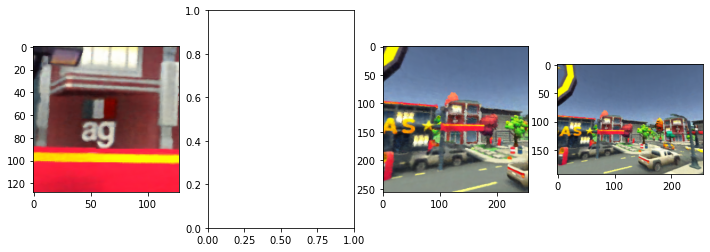

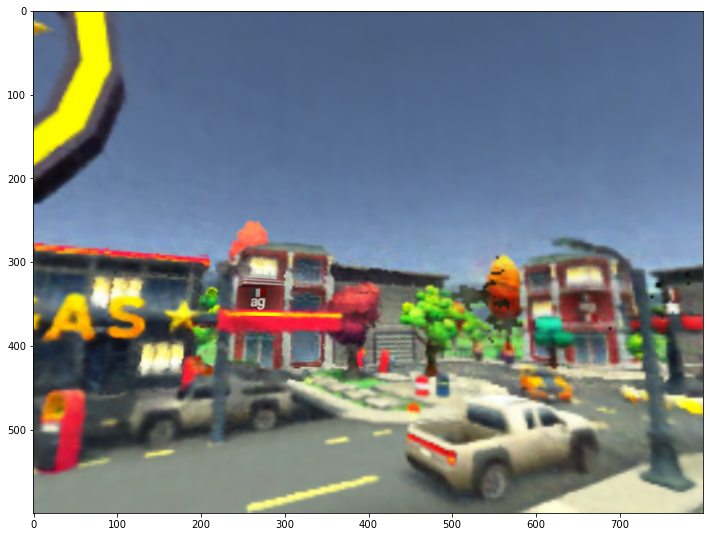

In [4]:
view_coord = [val // 2 for val in view_dataset.samples]
view_coord[0] += 1
view_coord[1] -= 1
view_coord[3] += 3
view_coord[4] += 1
fovea_center = (-0.16, 0.07)
#fovea_center = (0.15, -0.08)

view_idx = indices[tuple(view_coord)]
view_o = view_dataset.view_centers[view_idx]  # (3)
view_r = view_dataset.view_rots[view_idx]  # (3, 3)
print(view_o, view_r)

fov_list = [10, 60, 70]
res_list = [(128, 128), (256, 256), (192,256)]#(256, 230)]
cams = [
    view.CameraParam({
        "fov": fov_list[i],
        "cx": 0.5,
        "cy": 0.5,
        "normalized": True
    }, res_list[i]).to(device.GetDevice())
    for i in range(len(fov_list))
]
fovea_cam, mid_cam, periph_cam = cams[0], cams[1], cams[2]
ref_cam_params = ref_dataset.cam_params
vr_cam = view.CameraParam({
    'fov': fov_list[-1],
    'cx': 0.5,
    'cy': 0.5,
    'normalized': True
}, (600, 800))
#}, (1600, 1440))
print(periph_cam.f, periph_cam.c, periph_cam.res)
foveation = Foveation(fov_list, vr_cam.res, device=device.GetDevice())
"""
bound_view_idxs = [
    ref_indices[view_coord[0] + 2 - 1, view_coord[1] + 2 + 1, view_coord[2],
                view_coord[3] - 1, view_coord[4] + 1],
    ref_indices[view_coord[0] + 2 + 1, view_coord[1] + 2 + 1, view_coord[2],
                view_coord[3] + 1, view_coord[4] + 1],
    ref_indices[view_coord[0] + 2 - 1, view_coord[1] + 2 - 1, view_coord[2],
                view_coord[3] - 1, view_coord[4] - 1],
    ref_indices[view_coord[0] + 2 + 1, view_coord[1] + 2 - 1, view_coord[2],
                view_coord[3] + 1, view_coord[4] - 1]
]
bounds_img = torch.cat([
    read_ref_images(idx).to(device.GetDevice())
    for idx in bound_view_idxs
], 0)
bounds_o = torch.stack([ref_dataset.view_centers[idx]
                        for idx in bound_view_idxs], 0)
bounds_r = torch.stack([ref_dataset.view_rots[idx]
                        for idx in bound_view_idxs], 0)
"""
fovea_center_full_res_offset = (
    (fovea_center[0] * vr_cam.res[1]),
    (fovea_center[1] * vr_cam.res[0])
)
fovea_offset = (
    (fovea_center[0] * vr_cam.res[1]) / vr_cam.f[0].item() * fovea_cam.f[0].item(),
    (fovea_center[1] * vr_cam.res[0]) / vr_cam.f[1].item() * fovea_cam.f[1].item()
)
fovea_cam.c[0] -= fovea_offset[0]
fovea_cam.c[1] -= fovea_offset[1]
mid_offset = (
    (fovea_center[0] * vr_cam.res[1]) / vr_cam.f[0].item() * mid_cam.f[0].item(),
    (fovea_center[1] * vr_cam.res[0]) / vr_cam.f[1].item() * mid_cam.f[1].item()
)
mid_cam.c[0] -= mid_offset[0]
mid_cam.c[1] -= mid_offset[1]
print(mid_offset)

perf = SimplePerf(True, True)

fovea_rays_o, fovea_rays_d = fovea_cam.get_global_rays(
    view_o, view_r)  # (H_fovea, W_fovea, 3)
mid_rays_o, mid_rays_d = mid_cam.get_global_rays(
    view_o, view_r)  # (H_mid, W_mid, 3)
periph_rays_o, periph_rays_d = periph_cam.get_global_rays(
    view_o, view_r)  # (H_periph, W_periph, 3)
mid_periph_rays_o = torch.cat([mid_rays_o.view(-1, 3), periph_rays_o.view(-1, 3)], 0)
mid_periph_rays_d = torch.cat([mid_rays_d.view(-1, 3), periph_rays_d.view(-1, 3)], 0)
perf.Checkpoint('Get rays')

perf1 = SimplePerf(True, True)

fovea_inferred, fovea_depthmap = fovea_net(
    fovea_rays_o.view(-1, 3), fovea_rays_d.view(-1, 3), ret_depth=True)
fovea_inferred = fovea_inferred.view(
    fovea_cam.res[0], fovea_cam.res[1], -1).permute(2, 0, 1)  # (C, H_fovea, W_fovea)
fovea_depthmap = fovea_depthmap.view(fovea_cam.res[0], fovea_cam.res[1])
perf1.Checkpoint('Infer fovea')

periph_mid_inferred = periph_net(mid_periph_rays_o,
                                 mid_periph_rays_d)  # (N, C)
mid_inferred = periph_mid_inferred[:mid_cam.res[0] * mid_cam.res[1], :].view(
    mid_cam.res[0], mid_cam.res[1], -1).permute(2, 0, 1)
periph_inferred = periph_mid_inferred[mid_cam.res[0] * mid_cam.res[1]:, :].view(
    periph_cam.res[0], periph_cam.res[1], -1).permute(2, 0, 1)
print(mid_inferred.size(), periph_inferred.size())
perf1.Checkpoint('Infer mid & periph')

perf.Checkpoint('Infer')

#fovea_refined = fovea_refine.refine(fovea_inferred, fovea_depthmap, fovea_rays_o, fovea_rays_d, bounds_img,
#                                    bounds_o, bounds_r, ref_cam_params, fovea_net, False)

perf.Checkpoint('Refine')

blended = foveation.synthesis([
    fovea_inferred[None, ...],
    mid_inferred[None, ...],
    periph_inferred[None, ...]
], (0.5 + fovea_center[0], 0.5 + fovea_center[1]))

perf.Checkpoint('Blend')

plt.figure(figsize=(12, 4))
plt.set_cmap('Greys_r')
plt.subplot(1, 4, 1)
util.PlotImageTensor(fovea_inferred)
plt.subplot(1, 4, 2)
#util.PlotImageTensor(fovea_refined)
plt.subplot(1, 4, 3)
util.PlotImageTensor(mid_inferred)
plt.subplot(1, 4, 4)
util.PlotImageTensor(periph_inferred)

plt.figure(figsize=(12, 12))
util.PlotImageTensor(blended)

util.CreateDirIfNeed('output')
util.WriteImageTensor(fovea_inferred, 'output/fovea_%04d.png' % view_idx)
util.WriteImageTensor(mid_inferred, 'output/mid_%04d.png' % view_idx)
util.WriteImageTensor(periph_inferred, 'output/periph_%04d.png' % view_idx)
util.WriteImageTensor(blended, 'output/blended_%04d.png' % view_idx)
